In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '1',
    '2',
    '3',
    'O',
    'X'
]

data = np.concatenate([
    np.load('/home/lee/Desktop/hand/dataset5/seq_1_1721695265.npy'),
    np.load('/home/lee/Desktop/hand/dataset5/seq_2_1721695265.npy'),
    np.load('/home/lee/Desktop/hand/dataset5/seq_3_1721695265.npy'),
    np.load('/home/lee/Desktop/hand/dataset5/seq_O_1721695265.npy'),
    np.load('/home/lee/Desktop/hand/dataset5/seq_X_1721695265.npy'),
], axis=0)

data.shape

(1025, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1025, 30, 99)
(1025,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

2024-07-24 15:24:40.916192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:24:41.127886: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 15:24:42.076236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lee/Desktop/xarm_ros2_moveit/install/xarm_planner/lib:/home/lee/Desktop/xarm_ros2

(1025, 5)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(922, 30, 99) (922, 5)
(103, 30, 99) (103, 5)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

2024-07-24 15:24:50.373073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 44,229
Trainable params: 44,229
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=300,
    callbacks=[
        ModelCheckpoint('models/model2_1.4.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=30, verbose=1, mode='auto')
    ]
)

Epoch 1/300
25/29 [========================>.....] - ETA: 0s - loss: 29.5305 - acc: 0.4725
Epoch 1: val_acc improved from -inf to 0.57282, saving model to models/model2_1.4.hdf5
29/29 [==============================] - 1s 14ms/step - loss: 27.9401 - acc: 0.4848 - val_loss: 28.7885 - val_acc: 0.5728 - lr: 0.0010
Epoch 2/300
25/29 [========================>.....] - ETA: 0s - loss: 23.8855 - acc: 0.5025
Epoch 2: val_acc did not improve from 0.57282
29/29 [==============================] - 0s 8ms/step - loss: 23.7695 - acc: 0.4881 - val_loss: 16.1332 - val_acc: 0.4272 - lr: 0.0010
Epoch 3/300
25/29 [========================>.....] - ETA: 0s - loss: 26.3614 - acc: 0.4975
Epoch 3: val_acc did not improve from 0.57282
29/29 [==============================] - 0s 8ms/step - loss: 25.8849 - acc: 0.5152 - val_loss: 20.2796 - val_acc: 0.5340 - lr: 0.0010
Epoch 4/300
29/29 [==============================] - ETA: 0s - loss: 11.7006 - acc: 0.6280
Epoch 4: val_acc improved from 0.57282 to 0.59223, sav

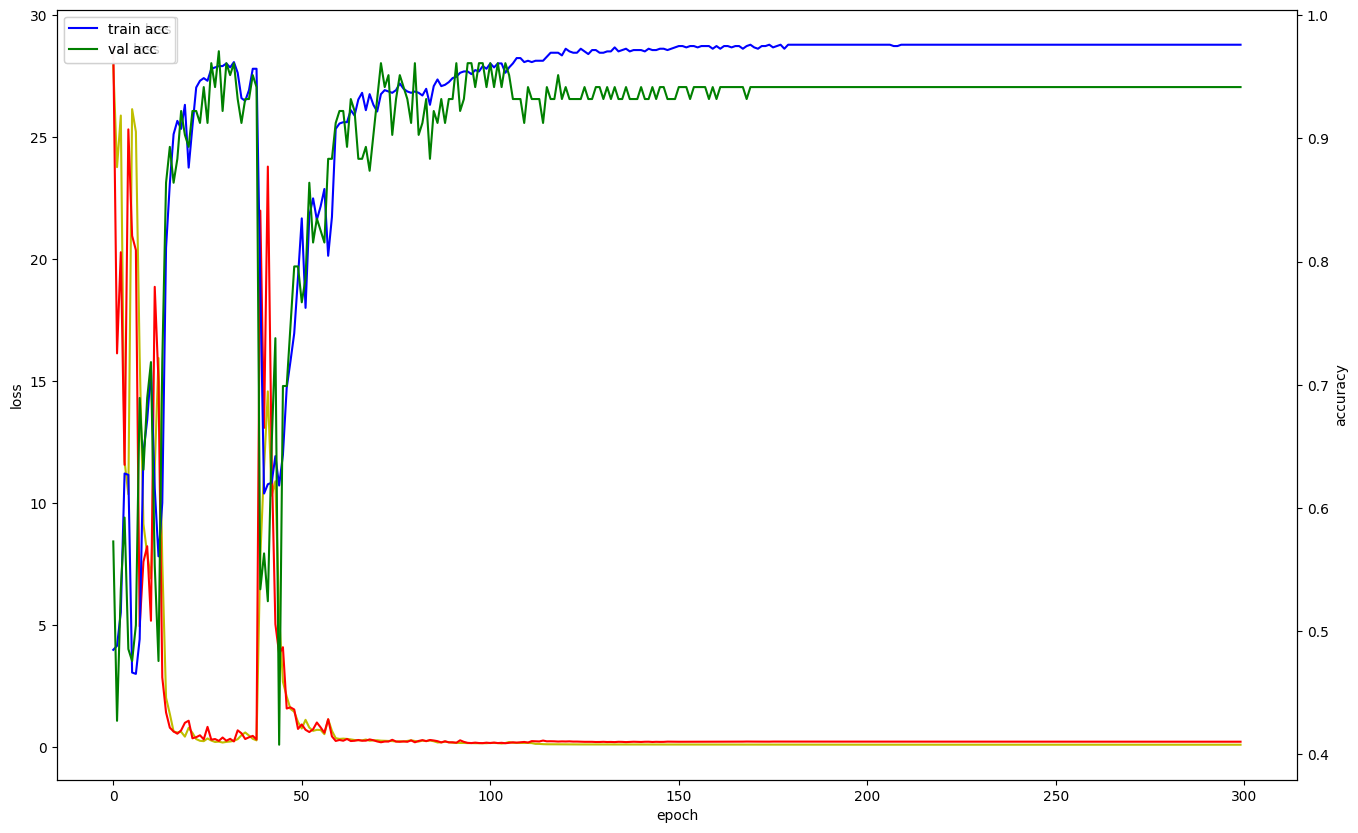

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model2_1.4.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

4/4 [==============================] - 0s 3ms/step


array([[[55,  0],
        [ 0, 48]],

       [[91,  1],
        [ 1, 10]],

       [[78,  0],
        [ 0, 25]],

       [[95,  0],
        [ 0,  8]],

       [[91,  1],
        [ 1, 10]]])